In [ ]:
!wget https://github.com/ChanCheeKean/datasets/blob/main/h5/deep_learning_h5.zip?raw=true
!unzip -qq deep_learning_h5.zip?raw=true

In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from lib.dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 1. Data Loading

In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

Classes: [b'non-cat' b'cat']
0


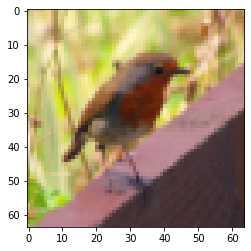

In [ ]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print(f'Classes: {classes}')
print(train_y[0, index])

In [ ]:
print(train_x_orig.shape)
print(test_x_orig.shape)
print(train_y.shape)

(209, 64, 64, 3)
(50, 64, 64, 3)
(1, 209)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="https://raw.githubusercontent.com/sebastianbirk/coursera-deep-learning-specialization/master/01_neural_networks_and_deep_learning/05_deep_neural_net_app/images/imvector.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [ ]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print(train_x.shape)
print(test_x.shape)

(12288, 209)
(12288, 50)


# 2. Model Architecture

## 2.1 Two layer neural network

<img src="https://raw.githubusercontent.com/sebastianbirk/coursera-deep-learning-specialization/master/01_neural_networks_and_deep_learning/05_deep_neural_net_app/images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.



In [ ]:
# layer shape
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [ ]:
# forward propagation
def initialize_parameters(n_x, n_h, n_y):
    # random weight
    W1 = np.random.randn(n_h, n_x) * 0.01 
    b1 = np.zeros((n_h, 1)) 
    W2 = np.random.randn(n_y, n_h)*0.01 
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def linear_forward(A, W, b):    
    Z = W.dot(A) + b
    cache = (A, W, b)
    return Z, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)    
    cache = Z 
    return A, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    return A, cache

def compute_cost(AL, Y):
    # ylog(a) + (1-y)log(1-a)
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y, np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))    
    cost = np.squeeze(cost)
    
    assert(cost.shape == ())
    return cost

In [ ]:
# backward propagation
def relu_backward(dA, cache):
    # cache: {Z}
    Z = cache
    dZ = np.array(dA, copy=True) # (Z.shape)
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    # cache: {Z}
    Z = cache
    s = 1 / (1+np.exp(-Z))
    dZ = dA * s * (1-s) # (Z.shape)
    return dZ

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ, A_prev.T) # (W.shape)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True) # (b.shape)
    dA_prev = np.dot(W.T, dZ) # (A_prev.shape)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    # linear_cache: {A, W, b}
    # activation_cache: {Z}
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def update_parameters(parameters, grads, learning_rate):
    # number of layers in the neural network
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [ ]:
# combination
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1] # (n_y, m)
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # (n_y, m)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp        
    return grads

def L_model_forward(X, parameters):
    caches = []
    A = X # (n_x, m)
    L = len(parameters) // 2 #layer number
    
    for l in range(1, L):
        A_prev = A # shape depending on layer
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu") # (n_h, m)
        caches.append(cache)
    
    # Final Layer Sigmoid
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid") # (n_y, m)
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    return AL, caches

In [ ]:
# predictions
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # layer number
    p = np.zeros((1, m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters) # (n_y, 209)
    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m))) 
    return p

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):

    grads, costs = {}, []               
    m = X.shape[1]                           
    (n_x, n_h, n_y) = layers_dims
    
    # initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"] # (n_h, n_x)
    b1 = parameters["b1"] # (n_h, 1)
    W2 = parameters["W2"] # (n_y, n_h)
    b2 = parameters["b2"] # (n_y, 1)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # forward propagation
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu") # (n_h, m)
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid") # (n_y, m)
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2)) # (n_y, m)
                
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid") #dA1.shape = (n_h, m)
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu") #dA0.shape = (n_x, m)
            
        # store gradients
        grads['dW1'] = dW1 # (n_h, n_x)
        grads['db1'] = db1 # (n_h, 1)
        grads['dW2'] = dW2 # (n_y, n_h)
        grads['db2'] = db2 # (n_y, 1)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

Cost after iteration 0: 0.6926547325716115
Cost after iteration 100: 0.645929749566515
Cost after iteration 200: 0.6313113314299669
Cost after iteration 300: 0.5985984537276393
Cost after iteration 400: 0.556334803156258


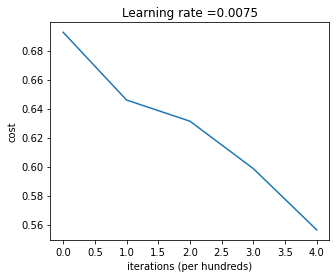

In [ ]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations=500, print_cost=True)

In [ ]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.6555023923444976
Accuracy: 0.3400000000000001


## 2.2 L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="https://raw.githubusercontent.com/sebastianbirk/coursera-deep-learning-specialization/master/01_neural_networks_and_deep_learning/05_deep_neural_net_app/images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

In [ ]:
# 4-layer model
layers_dims = [12288, 20, 7, 5, 1]

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    costs = []
    
    # Parameters initialization. 
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225


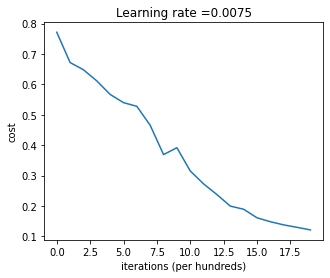

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations=2000, print_cost=True)

In [ ]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9808612440191385
Accuracy: 0.8


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

# 3. Results Analysis

In [ ]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

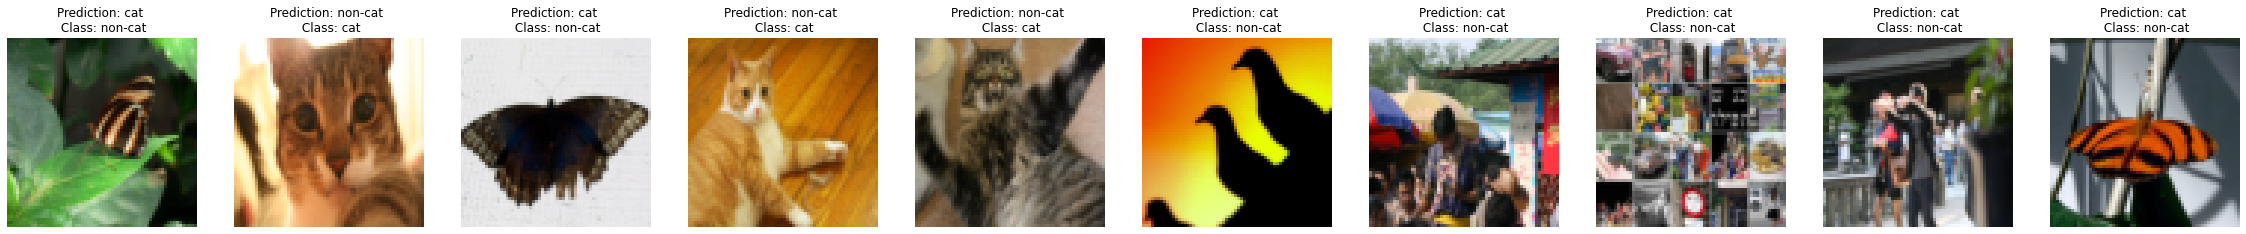

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 